In [41]:
library(Seurat)
library(SeuratDisk)
library(NMF)
library(ggalluvial)
library(ComplexHeatmap)
library(CellChat)
library(patchwork)
library(graphics)
library(Matrix)
library(circlize)
library(colorspace)
library(pracma)
library(glue)

options(stringsAsFactors = FALSE, repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 300)

source("../Scripts/A-Sender_Receiver_Chord.r")

# rankNet

In [48]:
cellchat.CT <- readRDS(file = "/extra/zhanglab0/CommonData/AMP-AD/Obj-CellChat/subclass_cellchat_control.rds")
cellchat.AD <- readRDS(file = "/extra/zhanglab0/CommonData/AMP-AD/Obj-CellChat/subclass_cellchat_alz.rds")

In [49]:
cellchat.CT <- updateCellChat(cellchat.CT)
cellchat.AD <- updateCellChat(cellchat.AD)

In [50]:
object.list <- list(AD = cellchat.AD, CON = cellchat.CT)
cellchat <- mergeCellChat(object.list, add.names = names(object.list))
print(cellchat)
names(object.list)

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



An object of class CellChat created from a merged object with multiple datasets 
 704 signaling genes.
 51171 cells. 
CellChat analysis of single cell RNA-seq data! 


[1] "AD"  "CON"

In [51]:
x = rankNet(cellchat, mode = "comparison", stacked = T, do.stat = TRUE, return.data = TRUE)

In [52]:
pdf(file = glue("figure4A.pdf"), width = 12, height = 12)

x

dev.off()

$signaling.contribution
                      name contribution contribution.scaled group
KIT                    KIT 0.000000e+00           0.0000000    AD
CRH                    CRH 0.000000e+00           0.0000000    AD
CCK                    CCK 7.632273e-02           0.3886839    AD
BMP                    BMP 4.008717e-01           1.0939557    AD
TAC                    TAC 5.408439e-02           0.3427933    AD
ANGPT                ANGPT 9.685418e-03           0.2156504    AD
VIP                    VIP 5.580071e-02           0.3465041    AD
WNT                    WNT 2.117007e-01           0.6440884    AD
SEMA3                SEMA3 2.210571e+00          15.6709613    AD
PARs                  PARs 9.248071e-01          12.7926215    AD
IGF                    IGF 2.565720e+00          15.9907768    AD
FGF                    FGF 1.641595e+00          15.0313302    AD
PDGF                  PDGF 5.873782e-01           1.8793942    AD
TGFb                  TGFb 1.948777e-02           0.

png 
  2

## Calculating Unique in 1 Disease

In [36]:
# for plotting figC, differential network
project = "AD_Paper"

type <- "truncatedMean"
trim <- 0.05
measure = 'weight'

In [38]:
celltype_name = c('Chandelier', 'Lamp5', 'Lamp5 Lhx6', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'Sst Chodl', 
                  'L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 
                  'Astro', 'Endo', 'Oligo', 'OPC', 'VLMC', 'Micro/PVM')

### Comparison

In [32]:
object.list_ADvCON <- list(CT = cellchat.CT, AD = cellchat.DIS)
cellchat_ADvCON <- mergeCellChat(object.list_ADvCON, add.names = names(object.list_ADvCON))
print(cellchat_ADvCON)
print(names(object.list_ADvCON))

AD_up <- c()
AD_down <- c()
signalings = unique(x$signaling.contribution$name)
for (signaling in signalings) {
    pval <- subset(x$signaling.contribution, name == signaling & group == "DIS")$pvalues
    rel_contrib <- subset(x$signaling.contribution, name == signaling & group == "DIS")$contribution.relative.1
    
    if (rel_contrib > 1.05 & pval < 0.05) {
        AD_down <- c(AD_down, signaling)
    } else if (rel_contrib < 0.95 & pval < 0.05) {
        AD_up <- c(AD_up, signaling)
    }
}

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



An object of class CellChat created from a merged object with multiple datasets 
 704 signaling genes.
 51171 cells. 
CellChat analysis of single cell RNA-seq data! 
[1] "CT" "AD"


# Code 

In [33]:
direction <- "to"
receiver = c('Oligo')
sender = c('')

## Cell Type

In [34]:
pathways.show      <- "all"

In [39]:
# get the matrix
obj1 <- object.list_ADvCON[[1]]@net[[measure]]              # CT
obj2 <- object.list_ADvCON[[2]]@net[[measure]]              # DIS
melt_1 <- reshape2::melt(obj1, value.name="count")
melt_2 <- reshape2::melt(obj2, value.name="count")
sum1 <- sum(melt_1$count)
sum2 <- sum(melt_2$count)

# balance
normalization_ADvCON = sum1 / sum2
# normalization = sum(object.list[[1]]@netP$prob) / sum(object.list[[2]]@netP$prob)
net.diff_ADvCON <- obj2 * (normalization_ADvCON) - obj1

# reorder the celltypes
net.diff_ADvCON <- net.diff_ADvCON[celltype_name, celltype_name]

net.diff_ADvCON[setdiff(celltype_name, sender), setdiff(celltype_name, receiver)] <- 0 

In [43]:
color.use = c(rainbow_hcl(9, c = 100), colorRampPalette(c("red", "orange"))(7), colorRampPalette(c("blue", "green"))(7))
color.use

[1] "#FF7A9E" "#F39525" "#BDAF00" "#59C200" "#00CD8D" "#00CBDA" "#00B7FF"
 [8] "#C890FF" "#FF72EA" "#FF0000" "#FF1B00" "#FF3700" "#FF5200" "#FF6E00"
[15] "#FF8900" "#FFA500" "#0000FF" "#002AD4" "#0055AA" "#007F7F" "#00AA55"
[22] "#00D42A" "#00FF00"

png 
  2

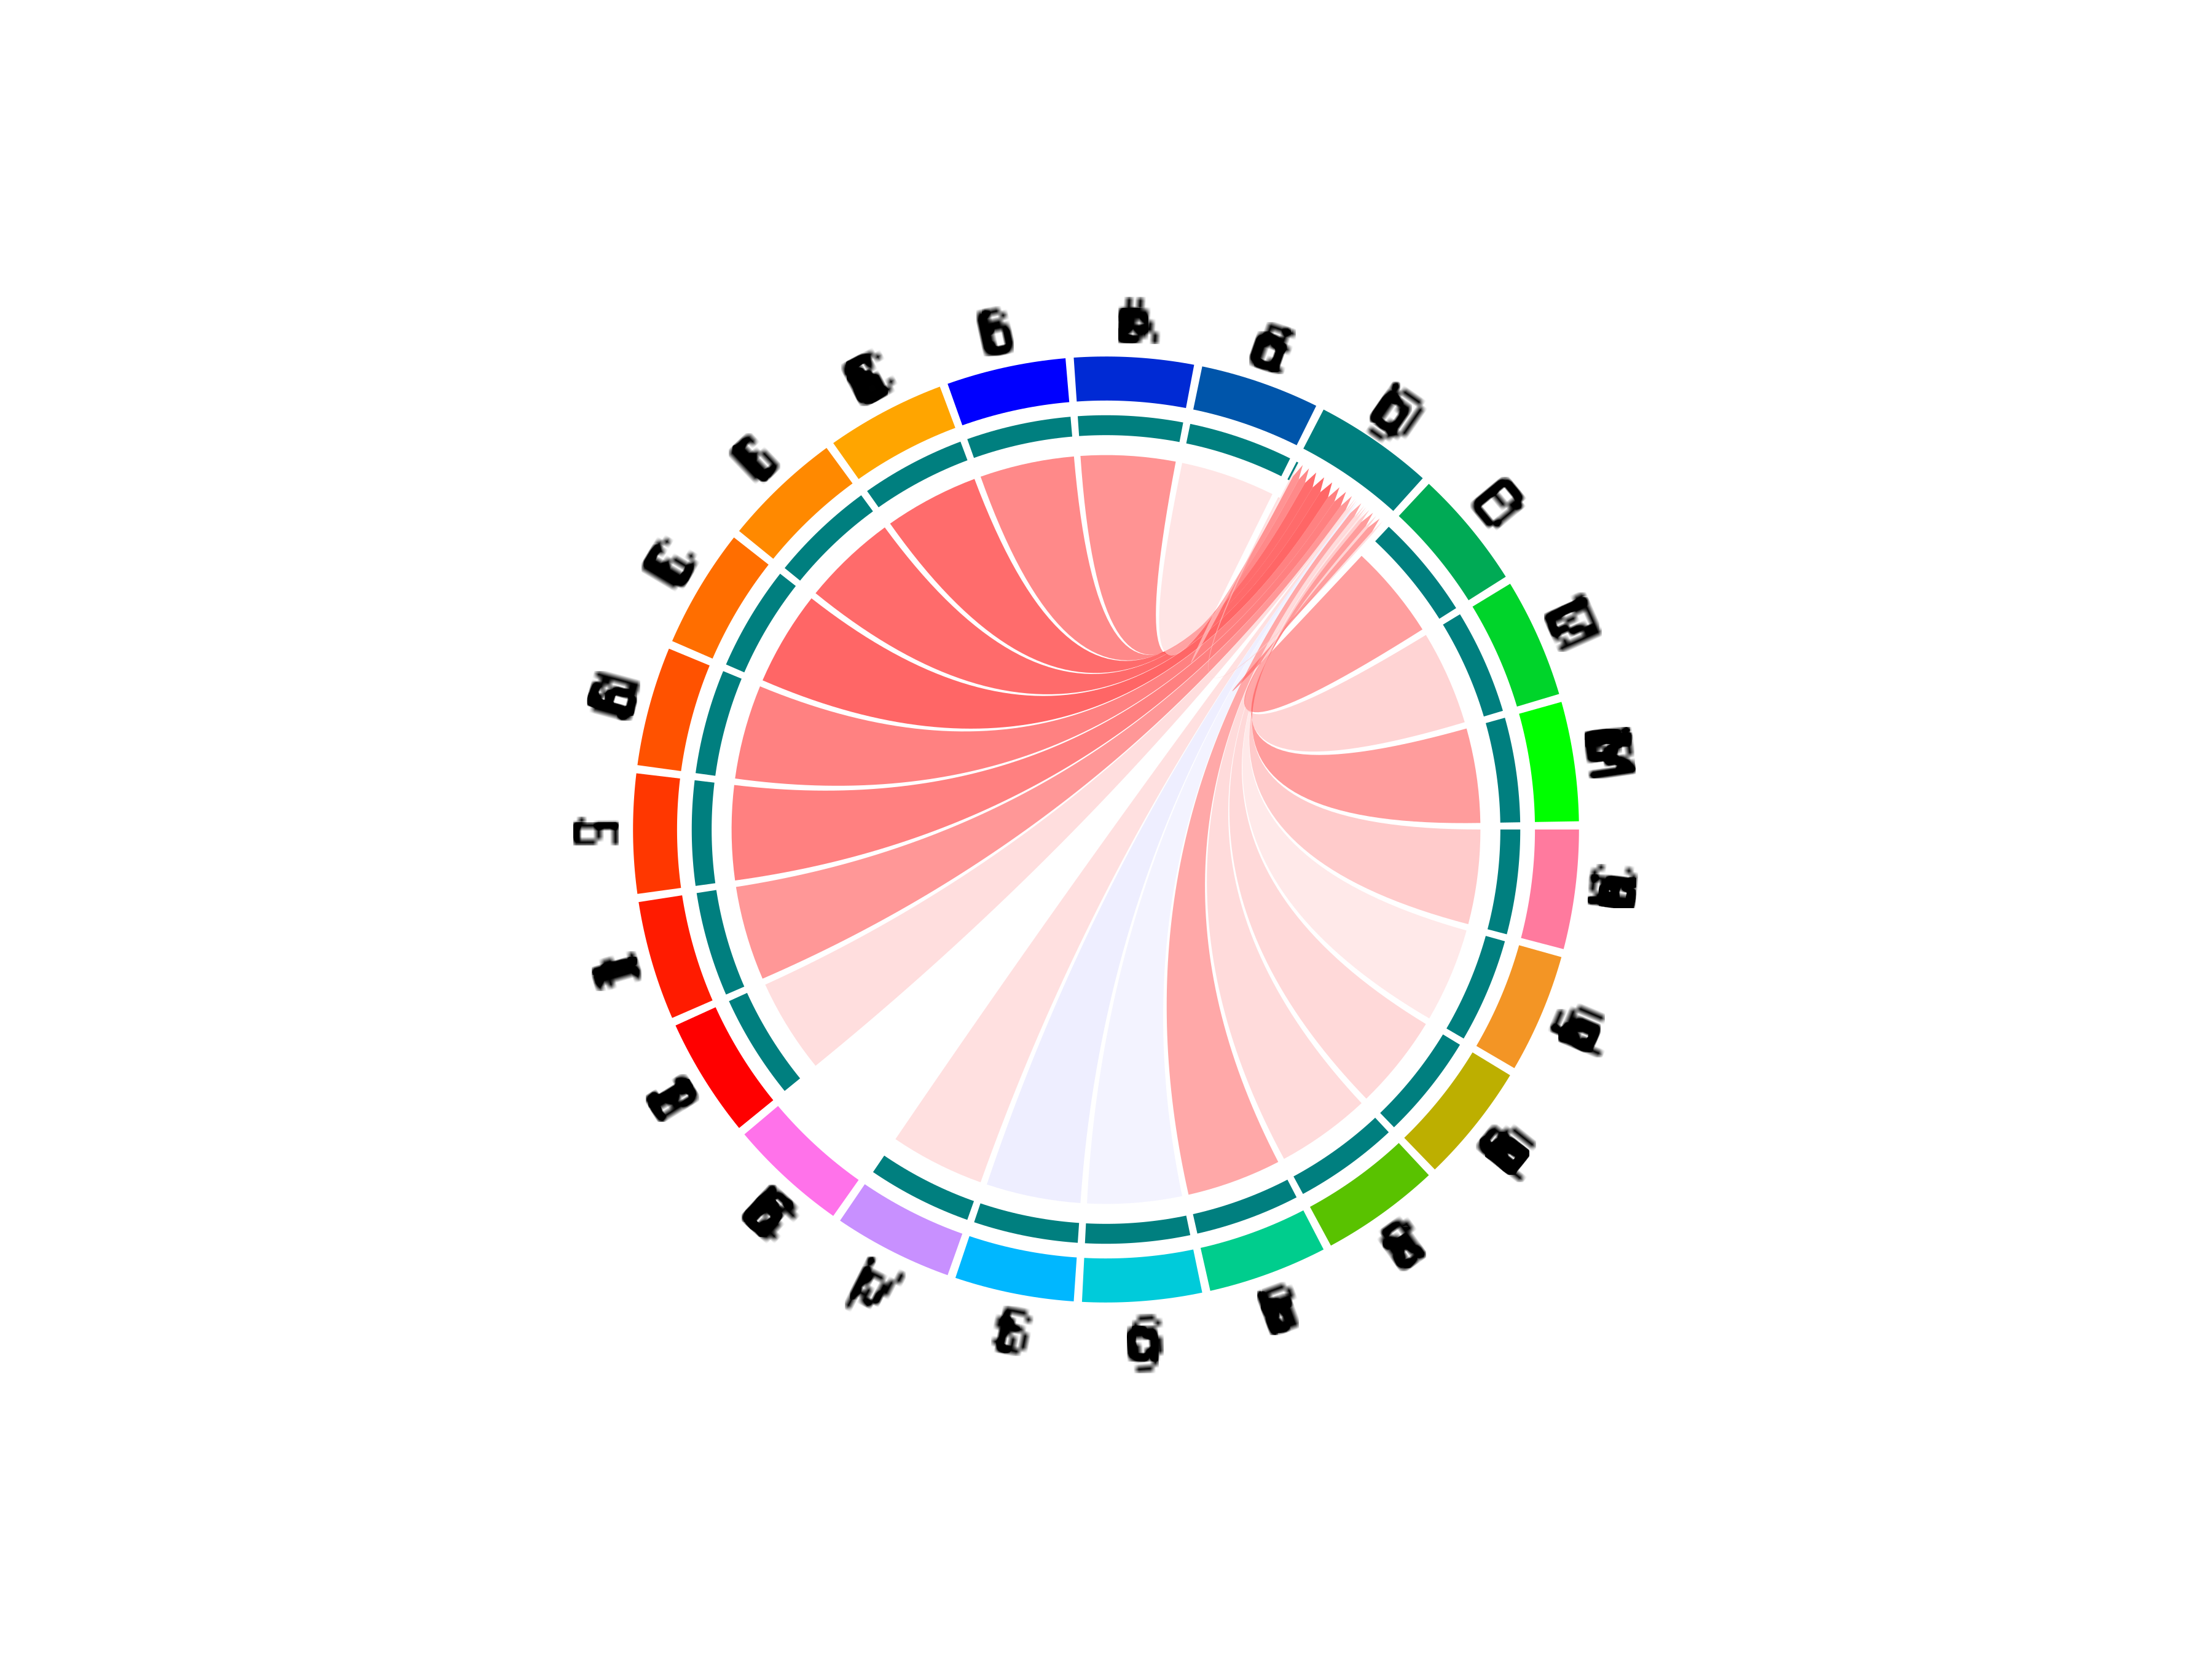

In [44]:
gg2 <- my_netVisual_aggregate2(net.diff_ADvCON, layout="chord", cell.order=celltype_name, signaling.name = pathways.show, 
                               color.use = color.use, vertex.label.cex = 2)

pdf(file = glue("chord-{direction}_{sender}{receiver}-{pathways.show}-{disease}.pdf"), 
    width = 12, height = 12)
print(gg2) 
dev.off()